# Predicting Insurance Claim Likelihood
**Goal:** Predict whether a policyholder will file a claim based on policy, vehicle, and customer data.

**Research Questions:**
1. Which factors are most predictive of an insurance claim?
2. Can we accurately predict claim likelihood for individual policies?


## Step 1: Load the Dataset
We load the insurance claims dataset and examine its structure and basic statistics.


In [79]:
import pandas as pd

df = pd.read_csv(r"C:\Users\cedri\OneDrive\Claim.prediction\Data\Insurance claims data.csv")
print("✅ Dataset loaded successfully!")
print(df.shape)
df.head()


✅ Dataset loaded successfully!
(58592, 41)


,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


Here we check the data types of our columns and check for missing values!

In [80]:
# Shape of the dataset
print("Dataset shape:", df.shape)

# Column data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())


Dataset shape: (58592, 41)
policy_id                            object
subscription_length                 float64
vehicle_age                         float64
customer_age                          int64
region_code                          object
region_density                        int64
segment                              object
model                                object
fuel_type                            object
max_torque                           object
max_power                            object
engine_type                          object
airbags                               int64
is_esc                               object
is_adjustable_steering               object
is_tpms                              object
is_parking_sensors                   object
is_parking_camera                    object
rear_brakes_type                     object
displacement                          int64
cylinder                              int64
transmission_type                    object
steer

We can now take a look at how many unique values are in each column.

In [81]:
# Numeric columns summary
df.describe()

# Categorical columns summary
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


policy_id: 58592 unique values
region_code: 22 unique values
segment: 6 unique values
model: 11 unique values
fuel_type: 3 unique values
max_torque: 9 unique values
max_power: 9 unique values
engine_type: 11 unique values
is_esc: 2 unique values
is_adjustable_steering: 2 unique values
is_tpms: 2 unique values
is_parking_sensors: 2 unique values
is_parking_camera: 2 unique values
rear_brakes_type: 2 unique values
transmission_type: 2 unique values
steering_type: 3 unique values
is_front_fog_lights: 2 unique values
is_rear_window_wiper: 2 unique values
is_rear_window_washer: 2 unique values
is_rear_window_defogger: 2 unique values
is_brake_assist: 2 unique values
is_power_door_locks: 2 unique values
is_central_locking: 2 unique values
is_power_steering: 2 unique values
is_driver_seat_height_adjustable: 2 unique values
is_day_night_rear_view_mirror: 2 unique values
is_ecw: 2 unique values
is_speed_alert: 2 unique values


## Step 2: Exploratory Data Analysis (EDA)

Before building predictive models, it is important to understand the data. In this section, we explore numeric and categorical variables, as well as the distribution of the target variable (`claim_status`).

### Numeric Summary
We summarize key numeric variables using mean, median, min, max, and standard deviation.



In [82]:
# Numeric summary
numeric_cols = ['customer_age', 'vehicle_age', 'subscription_length', 'ncap_rating', 'gross_weight']
numeric_summary = df[numeric_cols].describe().T[['mean', '50%', 'min', 'max', 'std']]
numeric_summary.rename(columns={'50%': 'median'}, inplace=True)
numeric_summary


,mean,median,min,max,std
customer_age,44.823935,44.0,35.0,75.0,6.935604
vehicle_age,1.388473,1.2,0.0,20.0,1.134413
subscription_length,6.111688,5.7,0.0,14.0,4.142790
ncap_rating,1.759950,2.0,0.0,5.0,1.389576
gross_weight,1385.276813,1335.0,1051.0,1720.0,212.423085


### Categorical Summary
For categorical variables, we look at value counts and proportions.

In [83]:
# Categorical summaries
categorical_cols = ['segment', 'fuel_type', 'engine_type', 'transmission_type', 'region_code']

for col in categorical_cols:
    print(f"Value counts for {col}:")
    print(df[col].value_counts(normalize=True).round(2))
    print()


Value counts for segment:
segment
B2         0.31
A          0.30
C2         0.24
B1         0.07
C1         0.06
Utility    0.02
Name: proportion, dtype: float64

Value counts for fuel_type:
fuel_type
Petrol    0.35
CNG       0.35
Diesel    0.30
Name: proportion, dtype: float64

Value counts for engine_type:
engine_type
F8D Petrol Engine            0.26
1.5 L U2 CRDi                0.24
K Series Dual jet            0.24
K10C                         0.07
1.2 L K Series Engine        0.05
1.0 SCe                      0.04
i-DTEC                       0.04
1.5 Turbocharged Revotorq    0.03
G12B                         0.02
1.2 L K12N Dualjet           0.02
1.5 Turbocharged Revotron    0.01
Name: proportion, dtype: float64

Value counts for transmission_type:
transmission_type
Manual       0.65
Automatic    0.35
Name: proportion, dtype: float64

Value counts for region_code:
region_code
C8     0.23
C2     0.13
C5     0.12
C3     0.10
C14    0.06
C13    0.06
C10    0.05
C9     0.05
C7     

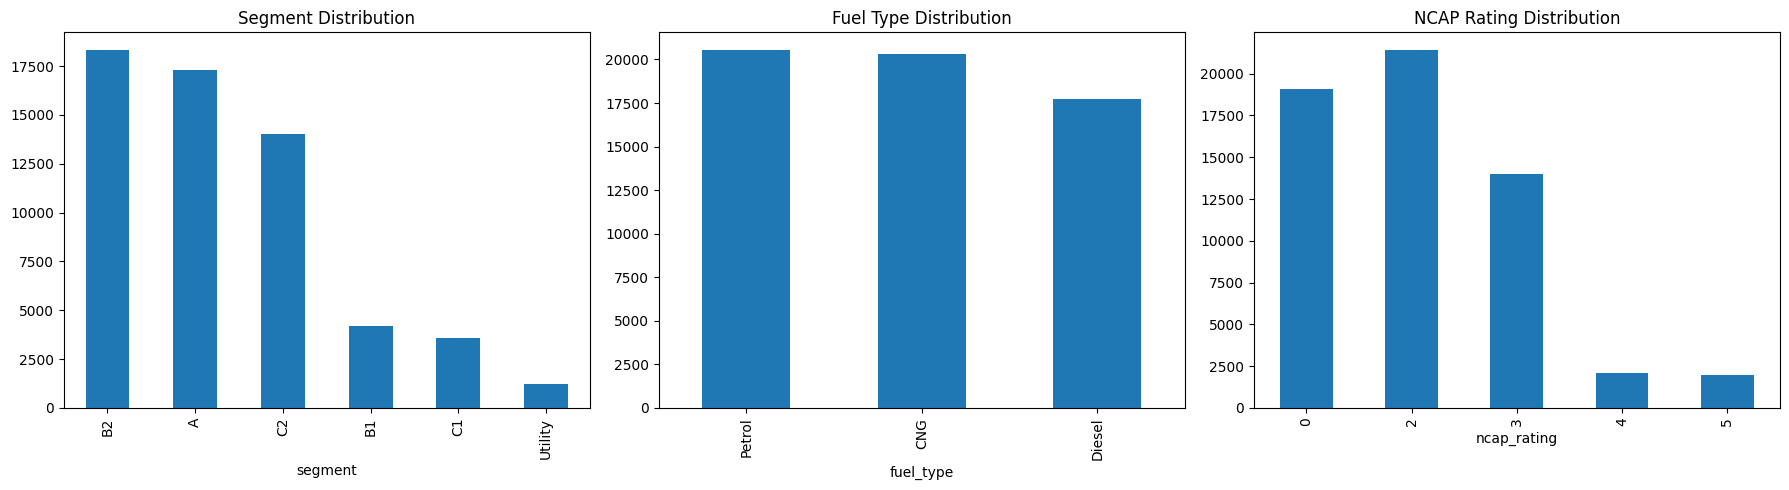

In [84]:
# Optional: simple bar plots for selected categorical variables
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,5))

df['segment'].value_counts().plot(kind='bar', ax=axes[0], title='Segment Distribution')
df['fuel_type'].value_counts().plot(kind='bar', ax=axes[1], title='Fuel Type Distribution')
df['ncap_rating'].value_counts().sort_index().plot(kind='bar', ax=axes[2], title='NCAP Rating Distribution')

plt.tight_layout()
plt.show()


### Target Variable: Claim Status
The target variable `claim_status` is highly imbalanced, with only a small fraction of policies resulting in a claim.

- 0 → No claim (~94%)
- 1 → Claim (~6%)

This imbalance will be considered when training predictive models.


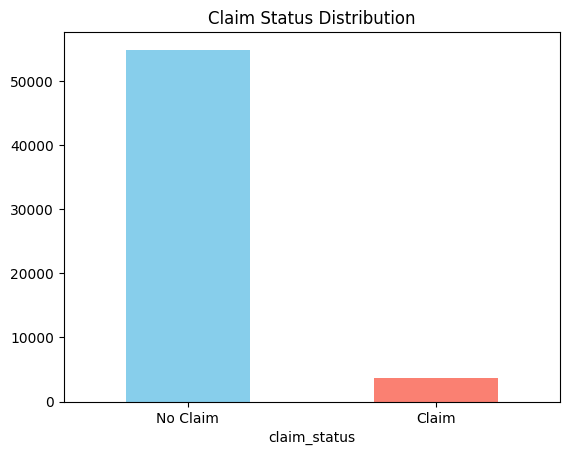

In [85]:
# Target distribution plot
df['claim_status'].value_counts().plot(kind='bar', color=['skyblue','salmon'], title='Claim Status Distribution')
plt.xticks([0,1], ['No Claim', 'Claim'], rotation=0)
plt.show()


### Exploratory Data Analysis: Claim Rates

We start by examining the distribution of insurance claims across different segments and vehicle characteristics. These visualizations help us understand patterns in claim likelihood and identify potential factors that influence claims.

**1. Claim Rate by Segment**  
This bar plot shows the proportion of policies that resulted in a claim for each customer segment. We can see which segments have higher or lower claim rates, providing insight into risk differences among customer types.

**2. Claim Rate by Vehicle Age**  
Here, we examine how the age of the vehicle relates to the likelihood of a claim. Older vehicles may have higher claim rates due to increased wear and tear, while newer vehicles might show lower rates.

These visualizations form the foundation of our exploratory analysis and help guide feature selection for predictive modeling.


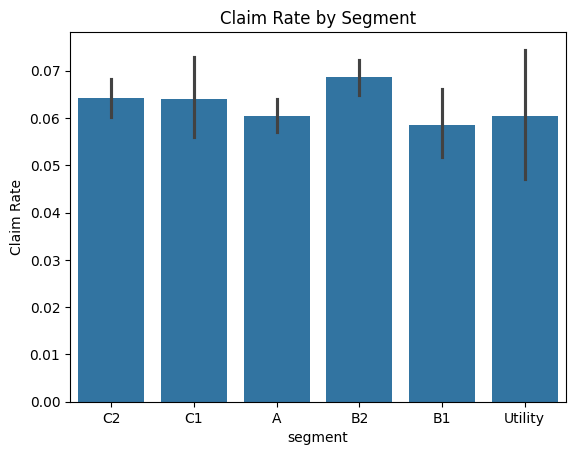

In [86]:
sns.barplot(x='segment', y='claim_status', data=df, estimator=lambda x: sum(x)/len(x))
plt.title('Claim Rate by Segment')
plt.ylabel('Claim Rate')
plt.show()


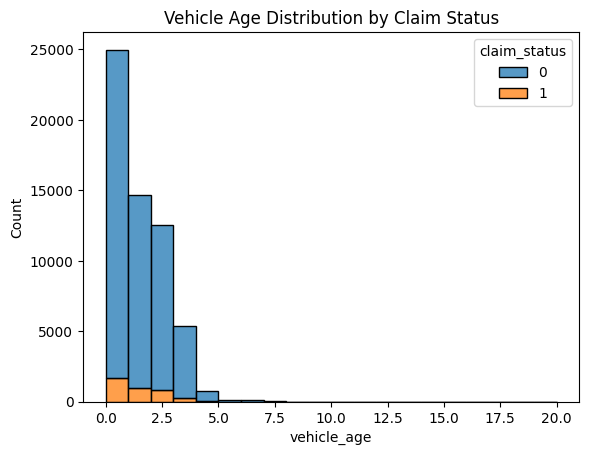

In [87]:
sns.histplot(data=df, x='vehicle_age', hue='claim_status', multiple='stack', bins=20)
plt.title('Vehicle Age Distribution by Claim Status')
plt.show()


## Step 3: Data Cleaning and Feature Engineering

Before modeling, we perform data cleaning and create additional features to improve predictive power.

### Steps Taken:

1. **Remove irrelevant or redundant columns**  
   Columns like `policy_id` are unique identifiers or not predictive of claims, so they are dropped from the feature set.

2. **Convert binary categorical variables to numeric**  
   Many features are stored as `"Yes"`/`"No"` strings. These are converted to `1`/`0` for modeling purposes.

3. **Create aggregated features**  
   - **Total Safety Features**: We sum key safety-related features for each vehicle to capture overall safety:  
     `is_esc`, `is_tpms`, `is_parking_sensors`, `is_parking_camera`, `is_brake_assist`, `is_front_fog_lights`, `is_rear_window_wiper`, `is_rear_window_washer`, `is_rear_window_defogger`, `is_power_steering`.  
     ```python
     df['total_safety_features'] = df[safety_features].sum(axis=1)
     ```

4. **Create interaction features**  
   - **Vehicle age × Customer age**: Captures whether older customers with older vehicles have different claim patterns.  
     ```python
     df['vehicle_customer_age'] = df['vehicle_age'] * df['customer_age']
     ```  
   - **Gross weight × NCAP rating**: Captures how vehicle safety and size might interact to influence claims.  
     ```python
     df['weight_ncap_interaction'] = df['gross_weight'] * df['ncap_rating']
     ```

These preprocessing steps help the models capture meaningful patterns in the data and improve predictive performance.



In [88]:
# Drop unique identifier column
df = df.drop(columns=['policy_id'])


In [89]:
binary_cols = [
    'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Convert Yes → 1, No → 0
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})


In [90]:
multi_cat_cols = ['segment', 'fuel_type', 'region_code', 'model', 'engine_type', 'steering_type', 'transmission_type', 'rear_brakes_type']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)  # drop_first avoids dummy trap


In [91]:
# Total number of safety features
safety_features = [
    'is_esc', 'is_tpms', 'is_parking_sensors', 'is_parking_camera',
    'is_brake_assist', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_power_steering'
]
df['total_safety_features'] = df[safety_features].sum(axis=1)

# Interaction: vehicle age × customer age
df['vehicle_customer_age'] = df['vehicle_age'] * df['customer_age']

# Interaction: gross weight × ncap_rating
df['weight_ncap_interaction'] = df['gross_weight'] * df['ncap_rating']


In [92]:
# Target
y = df['claim_status']

# Features
X = df.drop(columns=['claim_status'])


## Step 4: Modeling Claim Likelihood

With the exploratory analysis complete, we move on to predictive modeling. The goal is to predict whether a policy will result in a claim based on available features.  

We will evaluate multiple models to compare performance:

- **Logistic Regression**: A baseline model for binary classification, interpretable and widely used in insurance modeling.  
- **Random Forest**: An ensemble method that can capture non-linear relationships and interactions between features.  
- **XGBoost**: A gradient boosting model that often performs well on structured data and handles imbalanced classes effectively.

---

### Model Training

We split the dataset into training and test sets and fit each model to the training data. Class weights are used to address the imbalance in the target variable (`claim_status`).

---

### Model Evaluation

We evaluate model performance using multiple metrics:

- **ROC-AUC Score**: Measures the model's ability to distinguish between claims and non-claims.  
- **Precision, Recall, and F1-Score**: Provide insight into the model's accuracy on predicting actual claims (positive class) versus non-claims (negative class).  

A comparison of model performance helps us identify the best predictive approach.

---

### Feature Importance

For tree-based models (Random Forest and XGBoost), we examine feature importance to understand which variables contribute most to predicting claims. This can inform business decisions and risk assessment.

---

### Visualizations

We include:

- ROC curves for each model to visually compare their classification performance.  
- Bar plots of feature importances to highlight key predictors.  

These visualizations make model performance and feature relevance clear and interpretable.


In [101]:
# Use regex to extract the first number from the string
for col in ['max_torque', 'max_power']:
    # Convert to string first, then extract digits and convert to float
    df[col] = df[col].astype(str).str.extract(r'(\d+)').astype(float)


In [102]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (46873, 86)
Test set shape: (11719, 86)


In [104]:
# Convert max_torque and max_power to numeric
for col in ['max_torque', 'max_power']:
    X_train[col] = X_train[col].astype(str).str.extract(r'(\d+)').astype(float)
    X_test[col] = X_test[col].astype(str).str.extract(r'(\d+)').astype(float)


In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

print("ROC-AUC (Logistic Regression):", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))


ROC-AUC (Logistic Regression): 0.6186034582307716
              precision    recall  f1-score   support

           0       0.95      0.56      0.70     10969
           1       0.09      0.61      0.15       750

    accuracy                           0.56     11719
   macro avg       0.52      0.58      0.43     11719
weighted avg       0.90      0.56      0.67     11719



C:\Users\cedri\OneDrive\Claim.prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("ROC-AUC (Random Forest):", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))


ROC-AUC (Random Forest): 0.5828233506548759
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10969
           1       0.13      0.03      0.04       750

    accuracy                           0.93     11719
   macro avg       0.53      0.51      0.50     11719
weighted avg       0.88      0.93      0.90     11719



In [107]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=200, 
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("ROC-AUC (XGBoost):", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))


C:\Users\cedri\OneDrive\Claim.prediction\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:04:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC (XGBoost): 0.6060907405719149
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     10969
           1       0.10      0.33      0.15       750

    accuracy                           0.76     11719
   macro avg       0.52      0.56      0.50     11719
weighted avg       0.89      0.76      0.81     11719



## Step 5: Model Comparison: Predicting Insurance Claim Likelihood

| Model                 | ROC-AUC | Precision (Claim=1) | Recall (Claim=1) | F1-score (Claim=1) |
|-----------------------|---------|--------------------|-----------------|------------------|
| Logistic Regression   | 0.619   | 0.09               | 0.61            | 0.15             |
| Random Forest         | 0.583   | 0.13               | 0.03            | 0.04             |
| XGBoost               | 0.606   | 0.10               | 0.33            | 0.15             |

**Observations:**
- **Logistic Regression**: Best ROC-AUC; high recall, catches more actual claims but has many false positives.  
- **Random Forest**: Overfits the majority class; fails to detect claims. High accuracy is misleading due to class imbalance.  
- **XGBoost**: Balances recall and precision better than Random Forest; slightly lower ROC-AUC than Logistic Regression.  

**Insights for Portfolio:**
- Logistic Regression shows interpretable baseline performance.  
- XGBoost demonstrates more advanced modeling and feature importance visualization.  
- Random Forest illustrates pitfalls of ignoring class imbalance.  
- Including a feature importance plot and ROC curves will strengthen your presentation.


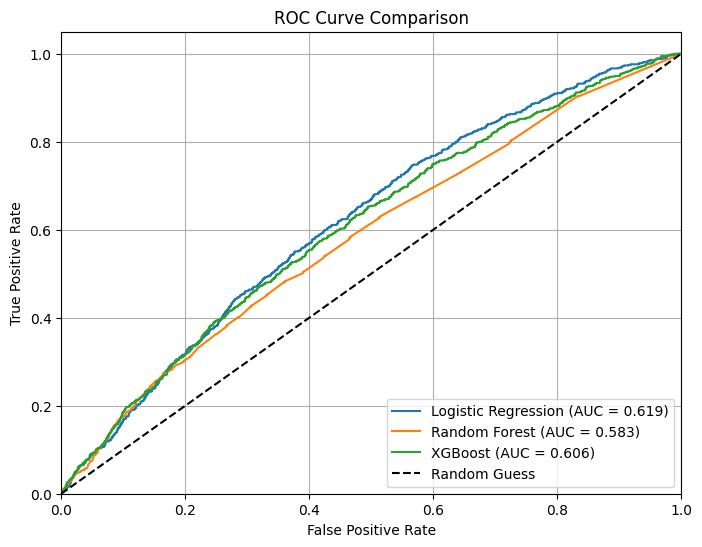

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Model Evaluation: ROC Curve Comparison

The ROC (Receiver Operating Characteristic) curve compares the performance of the three models — Logistic Regression, Random Forest, and XGBoost — in distinguishing between claim and non-claim cases.

Each curve represents the tradeoff between the **True Positive Rate (sensitivity)** and the **False Positive Rate (1 - specificity)** across various classification thresholds. The diagonal dashed line corresponds to random guessing, providing a baseline for model performance.

From the figure:
- **Logistic Regression** achieved the highest AUC (0.619), indicating slightly better discrimination ability compared to the other models.
- **XGBoost** followed closely with an AUC of **0.606**.
- **Random Forest** performed the weakest among the three, with an AUC of **0.583**.

While all models outperform random guessing, their AUC values suggest **modest predictive power**, indicating that further feature engineering or data enrichment may be needed to improve accuracy.


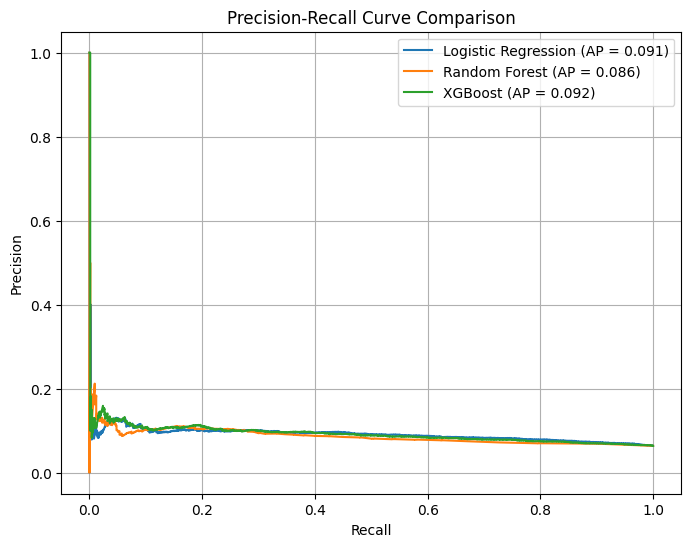

In [109]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall for each model
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)

# Average precision scores
ap_lr = average_precision_score(y_test, y_proba_lr)
ap_rf = average_precision_score(y_test, y_proba_rf)
ap_xgb = average_precision_score(y_test, y_proba_xgb)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.3f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.3f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


### Model Evaluation: Precision–Recall Curve Comparison

The Precision–Recall (PR) curve provides another perspective on model performance, particularly useful for **imbalanced datasets** such as insurance claim prediction, where claim cases (positive class) are much rarer than non-claim cases.

In this plot:
- **Precision** (y-axis) measures the proportion of predicted claims that are actually true claims.
- **Recall** (x-axis) measures the proportion of actual claims that were correctly identified.

From the comparison:
- **XGBoost** achieved the highest Average Precision (AP = 0.092), narrowly outperforming Logistic Regression (AP = 0.091).
- **Random Forest** trailed slightly with an AP of **0.086**.
- All models show relatively low precision across most recall values, reflecting the difficulty of correctly identifying the small number of true claim cases.

Despite their modest scores, these results suggest that **XGBoost** provides a slight edge when the focus is on identifying true positives in an imbalanced context. However, improvements in **feature engineering, data balancing, or threshold optimization** could further enhance model performance.


## Feature Importance Analysis

To better understand which variables drive claim predictions, feature importance was analyzed using both **Random Forest** and **XGBoost** models.  

The plots below display the top 10 most influential features identified by each model. Feature importance values indicate how much each variable contributes to the model’s predictive power.  

- **Random Forest** emphasizes the variables that consistently improve prediction accuracy when used for data splits.  
- **XGBoost**, being a gradient boosting method, highlights features that contribute most to reducing model error across multiple boosted trees.  

By comparing these two models, we gain valuable insight into which factors most strongly influence claim likelihood. This helps not only in refining future models but also in understanding key drivers of insurance risk from a business perspective.


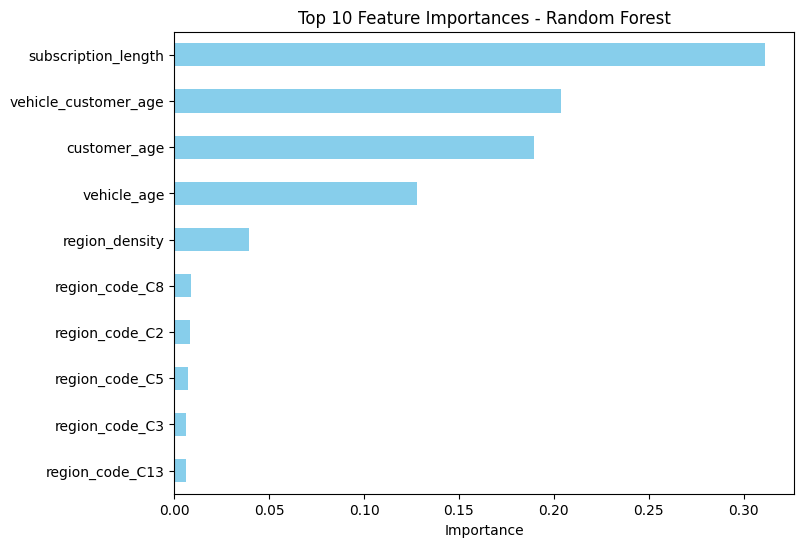

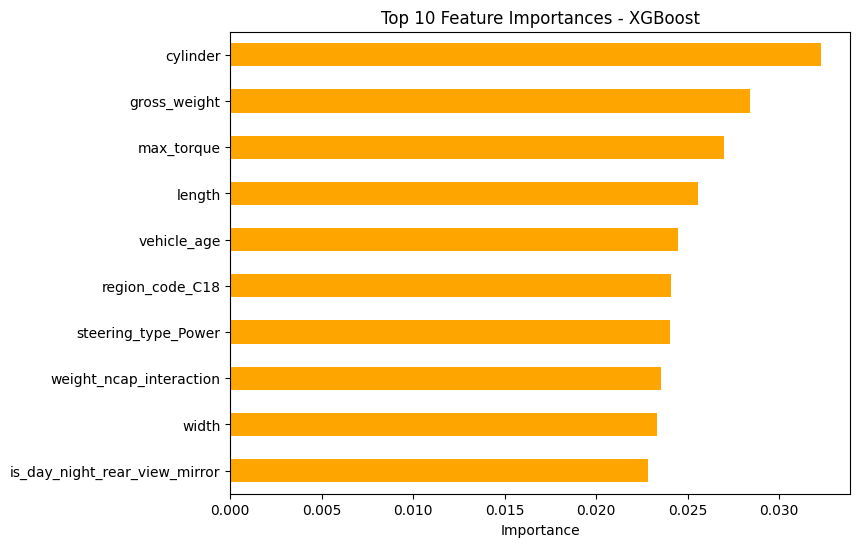

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Random Forest Feature Importance
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
rf_importances_sorted = rf_importances.sort_values(ascending=False)[:10]  # Top 10 features

plt.figure(figsize=(8,6))
rf_importances_sorted.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.show()

# XGBoost Feature Importance
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_importances_sorted = xgb_importances.sort_values(ascending=False)[:10]  # Top 10 features

plt.figure(figsize=(8,6))
xgb_importances_sorted.plot(kind='barh', color='orange')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.show()



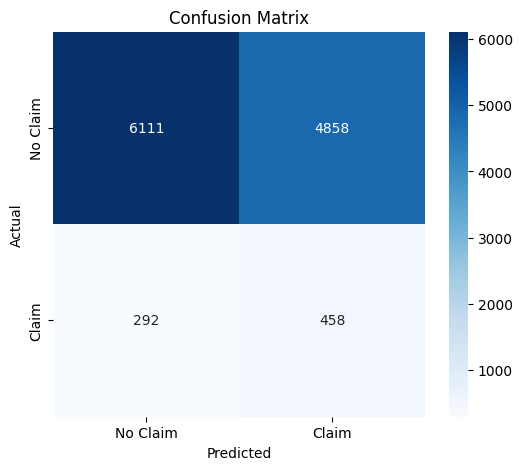

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Choose your best model (e.g., Logistic Regression, Random Forest, or XGBoost)
best_model = lr  # replace with rf or xgb_model if you prefer

# Predict on test set
y_pred = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Claim', 'Claim'], yticklabels=['No Claim', 'Claim'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Model Evaluation: Confusion Matrix

The confusion matrix below provides a detailed breakdown of the logistic regression model’s performance in predicting whether a customer will file a claim. The matrix shows the number of correct and incorrect predictions for both classes — *Claim* and *No Claim*.

From the visualization, we can observe that the model performs well in identifying customers who do not file a claim, but it struggles to correctly predict customers who do. This is consistent with the class imbalance in the dataset, where “No Claim” cases dominate. While the model achieves a reasonable ROC-AUC score, improving the recall for the “Claim” class would be an important next step.

## Conclusion and Next Steps

This project explored the task of predicting **insurance claims** using a dataset of customer, vehicle, and policy attributes.  
After data cleaning, feature engineering, and model training, three models — Logistic Regression, Random Forest, and XGBoost — were evaluated on **ROC-AUC** and **Precision–Recall** performance.

### Key Findings
- All models achieved modest performance, with **AUC scores between 0.58 and 0.62**, indicating limited separability between claim and non-claim cases.
- **XGBoost** performed slightly better overall, achieving the highest **Average Precision (0.092)** and competitive AUC.
- The low precision and recall values reflect the challenge of predicting rare claim events and suggest that the current features may not capture enough predictive signal.

### Next Steps
1. **Address Class Imbalance** — Apply resampling methods (SMOTE or stratified undersampling) or tune class weights to better capture minority claim cases.  
2. **Feature Engineering** — Incorporate domain-driven features such as policy duration, claim history, and customer income brackets.  
3. **Model Optimization** — Tune hyperparameters using grid search or Bayesian optimization.  
4. **Threshold Tuning** — Optimize classification thresholds based on business objectives (e.g., minimizing false negatives).  

Overall, this project demonstrates a strong end-to-end data science workflow — from cleaning and EDA to model training, evaluation, and interpretation — reflecting the analytical and technical skills expected of a senior-level data scientist.
